![](../images/logos.jpg "MiCMOR, KIT Campus Alpin")

**[MiCMOR](https://micmor.kit.edu) [SummerSchool "Environmental Data Science: From Data Exploration to Deep Learning"](https://micmor.kit.edu/sites/default/files/MICMoR%20Summer%20School%202019%20Flyer.pdf)**  
IMK-IFU KIT Campus Alpin, Sept. 4 - 13 2019, Garmisch-Partenkirchen, Germany.

---

# Working with geographic data

Python has a good selection of library that allow us to work with geographic datasets (raster and vector). In this notebook we will work with gridded data (using `xarray`), shapefiles (`geopandas`) and some smaller libs.

**TODO:** 
- Copy pgf3 data and and NUTs shapefile to virtual machines 
- Add regionmask package in virtual environments

**Noteworthy libraries we use in this notebook**. 

| Library   | Synopsis                                | Reference                      |
|:----------|:-----------------------------------------|:-------------------------------|
| **geopandas** | extends pandas for geodata (shapefiles) | [docs](https://geopandas.readthedocs.io/en/latest/)  |
| **regionmask**| select polygon regions from raster data | [docs](https://regionmask.readthedocs.io/en/stable/) |
| **xarray**    | labeled arrays and datasets             | [docs](http://xarray.pydata.org/en/stable/)          | 
| **shapely**   | work with geometries (basis for geopandas spatial features) | [docs](https://shapely.readthedocs.io/en/latest/) |

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [266]:
# we also need regionmask to convert polygone data to rasker masks
# ! pip install regionmask

In [2]:
import xarray as xr 
import numpy as np
import regionmask
import geopandas as gpd
import pandas as pd
from shapely import geometry
import matplotlib.pyplot as plt
import geoviews as gv   # remove?

/opt/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [268]:
# download European NUTs shapefile and unzip it
#! wget https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/download/ref-nuts-2016-10m.shp.zip
#! unzip ref-nuts-2016-10m.shp.zip

In [269]:
# also unzip the actual shapefile we want
#! unzip NUTS_RG_10M_2016_4326_LEVL_0.shp.zip

Lets load the shapefile and inspect some properties.    

In [4]:
nuts = gpd.read_file('../data/geodata/nuts/NUTS_RG_10M_2016_4326_LEVL_0.shp')
nuts.head()

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry
0,0,AL,AL,SHQIPÃRIA,AL,"POLYGON ((19.82698 42.4695, 19.83939 42.4695, ..."
1,0,AT,AT,ÃSTERREICH,AT,"POLYGON ((15.54245 48.9077, 15.75363 48.85218,..."
2,0,BE,BE,BELGIQUE-BELGIÃ,BE,"POLYGON ((5.10218 51.429, 5.0878 51.3823, 5.14..."
3,0,NL,NL,NEDERLAND,NL,"(POLYGON ((6.87491 53.40801, 6.91836 53.34529,..."
4,0,PL,PL,POLSKA,PL,"(POLYGON ((18.95003 54.35831, 19.35966 54.3723..."


In [5]:
nuts.shape

(37, 6)

As you can see this is just like a pandas dataframe. In addition, geopandas dataframes have a geometry column defining the spatial features and a Coordinate Reference System (crs) attribute attached that defines the projection. 

In this case, the geodataframe contains polygons (lines, points are also possible). A nice feature is that you can easily plot the data:

CRS of geodataframe: {'init': 'epsg:4326'}


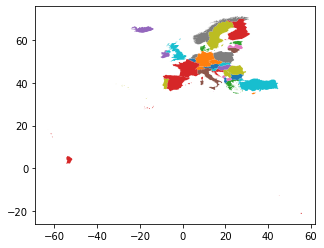

In [6]:
print(f'CRS of geodataframe: {nuts.crs}')
nuts.plot(column='NUTS_ID');


The crs is 4326. As you can see [here](https://epsg.io/4326) this is a plain, unprojected WGS84 system. 

As you can see we have French Guiana and various other overseas territories included in the file. However, if you remember, there were only single entries for each country in our dataframe. This means, that in case of France for instance, we do have so called *multi-part* polygons (multiple polygons that form one entity, you can see this in the geometry column).

Lets intersect the geodataframe with a boundary box we define. We do this using [shapely]()

In [7]:
# create a boundary shape (and make it lat/lon referenced using epsg:4326 )
boundary = gpd.GeoDataFrame({'ID': [0], 'geometry': geometry.Polygon([(-25, 33), (50,33), (50,75), (-25,75)])})
boundary.crs = {'init': 'epsg:4326'}
boundary

,ID,geometry
0,0,"POLYGON ((-25 33, 50 33, 50 75, -25 75, -25 33))"


Now we use the defined gboundary polygone to clip the area we want (continental europe).

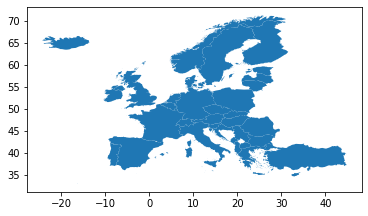

In [8]:
nuts_clipped = gpd.overlay(nuts, boundary, how='intersection')
nuts_clipped.plot();

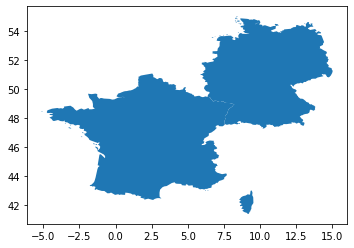

In [9]:
# Note that we can operate on geopandas dataframes like we would with regular pandas!
nuts_clipped[nuts_clipped.NUTS_ID.isin(['FR','DE'])].plot();

We now convert the shapefile into a regionmask. `regionmask` is just a tiny helper module (we could easily code this ourselves...)

In [10]:
nuts_mask_poly = regionmask.Regions_cls(name = 'nuts_mask', 
                                        numbers = list(range(len(nuts_clipped))), 
                                        names = list(nuts_clipped.NUTS_ID), 
                                        abbrevs = list(nuts_clipped.NUTS_ID), 
                                        outlines = list(nuts_clipped.geometry))
nuts_mask_poly

37 'nuts_mask' Regions ()
AL AT BE NL PL PT DK DE EL ES BG CH CY RO RS CZ EE HU HR SI SK SE IT TR FI NO IE IS LI LT LU LV ME MK UK MT FR

/opt/anaconda3/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/anaconda3/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


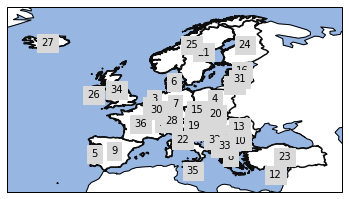

In [11]:
# lets check our regionmask
nuts_mask_poly.plot();

## Loading the climata data using xarray

In [14]:
# Open the Princeton Global Field v3 Reanalysis Dataset (0.25x0.25 deg resolution)
ds = xr.open_mfdataset('../datasets/pgf3/pgf_025deg_v3_*.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 600, lon: 1440, time: 6210)
Coordinates:
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2016-12-31
Data variables:
    tas      (time, lat, lon) float32 dask.array<shape=(6210, 600, 1440), chunksize=(366, 600, 1440)>
    prcp     (time, lat, lon) float32 dask.array<shape=(6210, 600, 1440), chunksize=(366, 600, 1440)>
Attributes:
    CDI:                       Climate Data Interface version 1.9.2 (http://m...
    history:                   Sat Apr 20 02:06:47 2019: cdo -P 4 sellonlatbo...
    Conventions:               CF-1.6
    title:                     Princeton University/University of Southampton...
    contact:                   Justin Sheffield (justin@princeton.edu)
    comment:                   This is an update to the original version repo...
    cdo_openmp_thread_number:  4

Now we create a raster mask that fits on the resolution of our climate data. We use just any variable contained in the dataset (here I chose tas) and only one time-step since we want a 2d array as reference.
In essence we are only after the dataset resoltuion so we can produce a raster mask that fits this resolution

In [15]:
# create int mask for europe (we use the same extent as with the previous clip)
nuts_mask = nuts_mask_poly.mask(ds.tas.isel(time=0).sel(lat=slice(33,75), lon=slice(-25,50)))

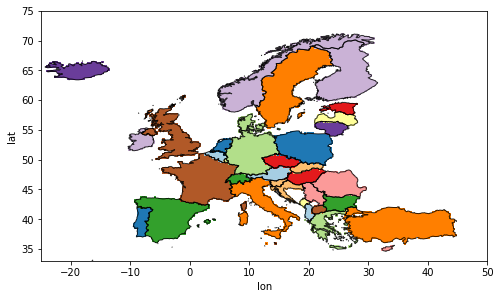

In [16]:
# plot the poly outlines and the created raster mask to check that we didn't mess up
fig, ax = plt.subplots(1, 1, figsize=(8,6))
nuts_mask.plot(cmap='Paired', add_colorbar=False)
nuts_clipped.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 1);

In [17]:
#create a quick lookup map to we can use country abbreviations to get the int ID they correspond to...
Dmap = dict(zip(nuts_mask_poly.abbrevs, nuts_mask_poly.numbers))

ID_REGION = Dmap['FR']
ID_REGION

36

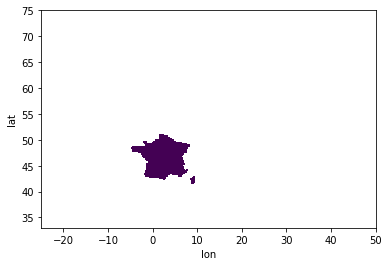

In [18]:
lat = nuts_mask.lat.values
lon = nuts_mask.lon.values

country_mask = nuts_mask.where(nuts_mask == ID_REGION) / ID_REGION
country_mask.plot(add_colorbar=False);

To speed-up the process we crop the xarray Dataset selecting the smallest box containing the entire mask. To do we store id_lon and id_lat the coordinate points where the mask has at least a non-nan value.

In [19]:
id_lon = lon[np.where(~np.all(np.isnan(country_mask), axis=0))]
id_lat = lat[np.where(~np.all(np.isnan(country_mask), axis=1))]

We then extract the region from the full xarray dataset. Calling compute actually executes the processing graph and this we actually use memory for tjis. Before we simply chained operations that did not comute anything.

In [20]:
ds_country = ds.sel(lat=slice(id_lat[0], id_lat[-1]), lon=slice(id_lon[0], id_lon[-1])).compute()
ds_country

<xarray.Dataset>
Dimensions:  (lat: 38, lon: 57, time: 6210)
Coordinates:
  * lon      (lon) float64 -4.625 -4.375 -4.125 -3.875 ... 8.875 9.125 9.375
  * lat      (lat) float64 41.62 41.88 42.12 42.38 ... 50.12 50.38 50.62 50.88
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2016-12-31
Data variables:
    tas      (time, lat, lon) float32 -0.1253418 -0.14874879 ... -8.05158
    prcp     (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:                       Climate Data Interface version 1.9.2 (http://m...
    history:                   Sat Apr 20 02:06:47 2019: cdo -P 4 sellonlatbo...
    Conventions:               CF-1.6
    title:                     Princeton University/University of Southampton...
    contact:                   Justin Sheffield (justin@princeton.edu)
    comment:                   This is an update to the original version repo...
    cdo_openmp_thread_number:  4
    NCO:                       netCDF Operators vers

Now we plot the temperature of the first day in the data. We use the region selected dataset (ds_country) for speed reasons and mask it with `where()`. We also add the NUTs vector layer for reference.

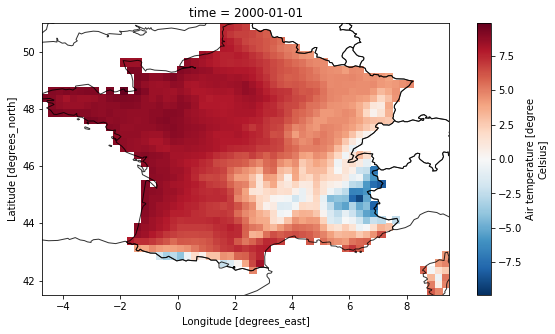

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ds_country.tas.isel(time = 0).where(country_mask==True).plot(ax = ax)
nuts.plot(ax = ax, alpha = 0.8, facecolor = 'none');

# Evaluating the entire timeseries

In [22]:
ts_mean = ds_country.tas.where(country_mask==True).mean(dim=['lat','lon'])
ts_min = ds_country.tas.where(country_mask==True).min(dim=['lat','lon'])
ts_max = ds_country.tas.where(country_mask==True).max(dim=['lat','lon'])

df = pd.DataFrame({'time': ts_mean.time, 
                   'tavg': ts_mean.values,
                   'tmin': ts_min.values,
                   'tmax': ts_max.values})
df.set_index('time', inplace=True)
df.head()

,tavg,tmin,tmax
time,,,
2000-01-01,5.650971,-8.994970,9.873316
2000-01-02,4.926337,-8.550604,9.591486
2000-01-03,4.784734,-11.028021,9.084284
2000-01-04,7.023589,-8.249975,10.175959
2000-01-05,7.101367,-6.321570,9.578363


In [23]:
df_r14d = df.rolling(14, center=True).mean()
df_r14d.head(14)

,tavg,tmin,tmax
time,,,
2000-01-01,NaN,NaN,NaN
2000-01-02,NaN,NaN,NaN
2000-01-03,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN
2000-01-08,4.568348,-7.543243,9.156885
2000-01-09,4.388251,-7.334679,9.125550


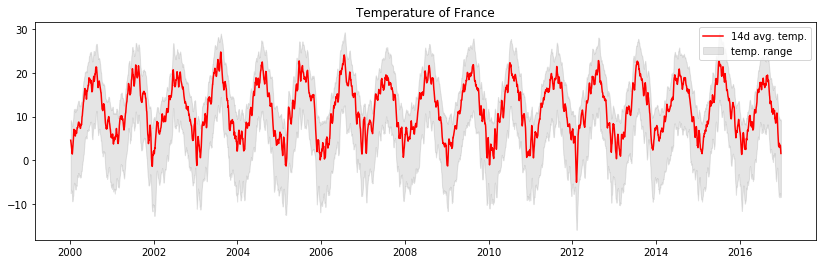

In [24]:
fig, ax = plt.subplots(1,1,figsize=(14,4))
ax.fill_between(df_r14d.index, df_r14d.tmin, df_r14d.tmax, color='gray', alpha=.2, label='temp. range')
ax.plot(df_r14d.index, df_r14d.tavg, color='red', label='14d avg. temp.')
ax.set_title('Temperature of France')
ax.legend();


We can repeat the same plot using hvplot.pandas and thus gaining interactive controls.

In [25]:
import hvplot.pandas
p1 = df_r14d.hvplot.area(y='tmin', y2='tmax', color='gray', alpha=.2, label='temp. range') 
p2 = df_r14d.hvplot.line(y='tavg', color='red', label='average', title='Temperature of France', )
(p1 * p2)

:Overlay
   .Area.Temp_full_stop_range :Area   [time]   (tmin,tmax)
   .Curve.Average             :Curve   [time]   (tavg)

# Temperature anomalies

We now want to look at monthly averages. We can do a special groupby over the time dimension: 'time.month'.

In [26]:
ds_mo = ds_country.where(country_mask==True).groupby('time.month').mean(dim='time')
ds_mo

/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (lat: 38, lon: 57, month: 12)
Coordinates:
  * lat      (lat) float64 41.62 41.88 42.12 42.38 ... 50.12 50.38 50.62 50.88
  * lon      (lon) float64 -4.625 -4.375 -4.125 -3.875 ... 8.875 9.125 9.375
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tas      (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    prcp     (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

The code above produced a monthly climatology. Notice that we now have a new dimension ('month') instead of 'time'.

Now we create the monthly temperatures for a given year (say 2013) before we calculate the monthly anomalies. Here you also see some xarray magic: you can select times with string syntax: '2013' for all timesteps of the year 2013, or a single day with '2013-01-01'...

In [27]:
ds_mo_2013 = ds_country.where(country_mask==True).sel(time = '2013').groupby('time.month').mean(dim='time')
ds_mo_2013

/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (lat: 38, lon: 57, month: 12)
Coordinates:
  * lat      (lat) float64 41.62 41.88 42.12 42.38 ... 50.12 50.38 50.62 50.88
  * lon      (lon) float64 -4.625 -4.375 -4.125 -3.875 ... 8.875 9.125 9.375
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tas      (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    prcp     (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

Now we calculate the monhtly anomalies and plot them as facets.

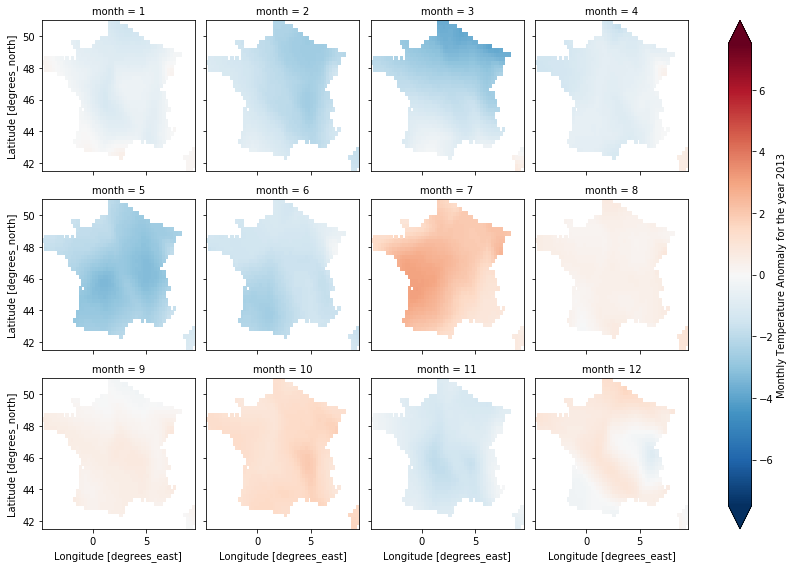

In [29]:
# calculate the monthly anomalies for the year 2013
target_year = 2013
(ds_mo_2013 - ds_mo).tas.plot(col='month', figsize=(12,8), col_wrap=4, aspect=1, 
                             vmin = -7.5, vmax = 7.5, cmap='RdBu_r', extend='both',
                             cbar_kwargs={'label': f'Monthly Temperature Anomaly for the year {target_year}'});

Ok, this is nice - but we want bling! We can use a proper projection and make the plot generally nicer.

/opt/anaconda3/lib/python3.7/site-packages/xarray/plot/facetgrid.py:288: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


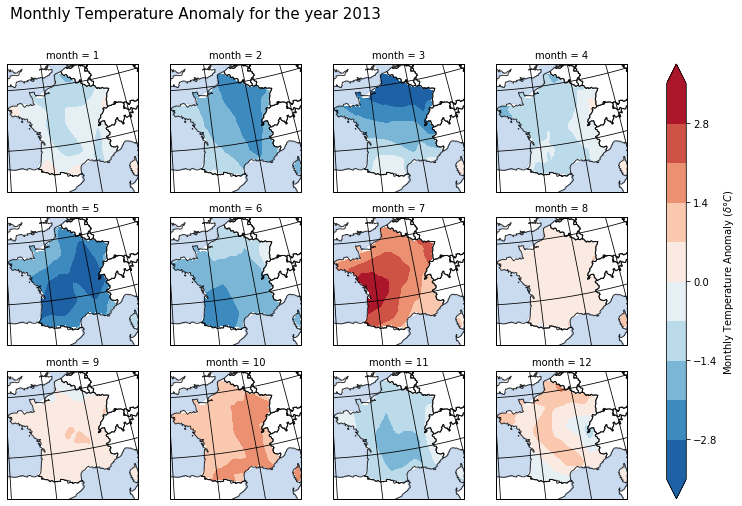

In [30]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.ticker as mticker

DATA_PROJ = ccrs.PlateCarree()
PLOT_PROJ = ccrs.Orthographic(-10, 45)

# define a faceted filled contour plot (that also has a catographic projection)
p = xr.plot.contourf((ds_mo_2013 - ds_mo).tas, col='month', col_wrap=4, 
                     vmin = -3.5, vmax = 3.5, levels=11, extend='both',
                     cmap='RdBu_r', 
                     figsize=(14,8), 
                     transform=DATA_PROJ, 
                     cbar_kwargs={'label': f'Monthly Temperature Anomaly ($\delta \degree C$)'},
                     subplot_kws={'projection': PLOT_PROJ});

# lets also style the subplots with our NUTs outlines, oceans background and a grid
for ax in p.axes.flat:
    nuts.plot(ax=ax, alpha = 0.8, facecolor = 'none', transform=ccrs.PlateCarree());

    # we define some custom gridlines
    gl = ax.gridlines(color='black')
    gl.xlocator = mticker.FixedLocator([-10,-5,0,5,10,15,20])
    gl.ylocator = mticker.FixedLocator([30,35,40,45,50,55])

    # also add a ocean background
    ax.add_feature(cartopy.feature.OCEAN, alpha=.5)
    
    # limit extent of map
    ax.set_extent([id_lon[0], id_lon[-1], id_lat[0], id_lat[-1]])

plt.suptitle(f'Monthly Temperature Anomaly for the year {target_year}', 
             horizontalalignment='right',
             fontsize=15);

# Extra: Compare temperature trends in 5 countries

In [32]:
countries = ['SE','DE','FR','UK','IT']
years = list(range(2000, 2017))

full_seas_results = []
full_yr_results = []

for country in countries:
    print(f'processing {country} ...')
    # create a country-specific mask
    country_mask = nuts_mask.where(nuts_mask == Dmap[country]) / Dmap[country]
    
    # cut appropriate region from full xarray dataset
    id_lon = lon[np.where(~np.all(np.isnan(country_mask), axis=0))]
    id_lat = lat[np.where(~np.all(np.isnan(country_mask), axis=1))]
    ds_country = ds.sel(lat=slice(id_lat[0], id_lat[-1]), lon=slice(id_lon[0], id_lon[-1])).where(country_mask==True).compute()

    # do aggregate stat - xarray does not do multiindex groupbys yet, so we need a loop...
    seas_climatology = ds_country.groupby('time.season').mean(dim='time')
    
    seas_results = []
    yr_results = []
    for year in years:
        seas = ds_country.sel(time=str(year)).groupby('time.season').mean(dim='time') - seas_climatology
        seas_results.append(seas)

        yr = ds_country.sel(time=str(year)).mean(dim='time') - ds_country.mean(dim='time')
        yr_results.append(yr)

    full_seas_results.append( xr.concat(seas_results, pd.Index(years, name='year')) )
    full_yr_results.append( xr.concat(yr_results, pd.Index(years, name='year')) )

ds_seas_full = xr.concat(full_seas_results, pd.Index(countries, name='country'))
ds_yr_full = xr.concat(full_yr_results, pd.Index(countries, name='country'))

processing SE ...


/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


processing DE ...


/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


processing FR ...


/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


processing UK ...


/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


processing IT ...


/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [33]:
ds_yr_full

<xarray.Dataset>
Dimensions:  (country: 5, lat: 133, lon: 128, year: 17)
Coordinates:
  * lat      (lat) float64 35.88 36.12 36.38 36.62 ... 68.12 68.38 68.62 68.88
  * lon      (lon) float64 -7.875 -7.625 -7.375 -7.125 ... 23.38 23.62 23.88
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2012 2013 2014 2015 2016
  * country  (country) object 'SE' 'DE' 'FR' 'UK' 'IT'
Data variables:
    tas      (country, year, lat, lon) float32 nan nan nan nan ... nan nan nan
    prcp     (country, year, lat, lon) float32 nan nan nan nan ... nan nan nan

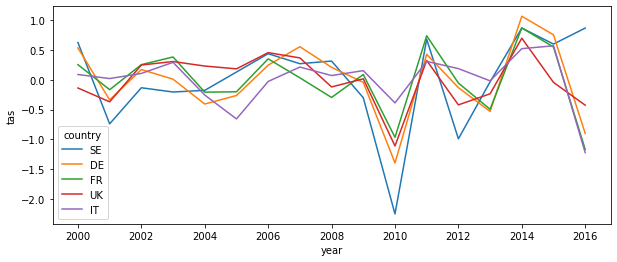

In [34]:
ds_yr_full.tas.mean(dim=['lat','lon']).plot(x='year', hue='country', figsize=(10,4));

In [35]:
ds_seas_full

<xarray.Dataset>
Dimensions:  (country: 5, lat: 133, lon: 128, season: 4, year: 17)
Coordinates:
  * lat      (lat) float64 35.88 36.12 36.38 36.62 ... 68.12 68.38 68.62 68.88
  * lon      (lon) float64 -7.875 -7.625 -7.375 -7.125 ... 23.38 23.62 23.88
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2012 2013 2014 2015 2016
  * country  (country) object 'SE' 'DE' 'FR' 'UK' 'IT'
Data variables:
    tas      (country, year, season, lat, lon) float32 nan nan nan ... nan nan
    prcp     (country, year, season, lat, lon) float32 nan nan nan ... nan nan

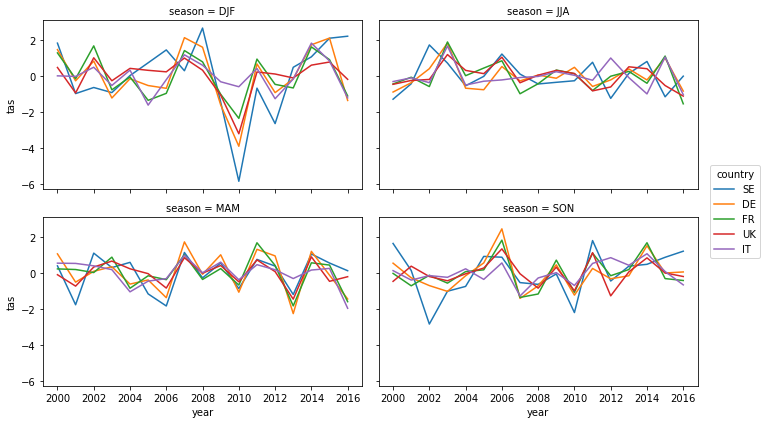

In [36]:
ds_seas_full.tas.mean(dim=['lat', 'lon']).plot(x='year', hue='country', col='season', col_wrap=2, figsize=(10,6));

# Excercises:

- repeat the analysis for a different country
- repeat the analysis for precipitation (var: prcp)